In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np

import ambulance_game as abg

In [2]:
def read_from_file(filename):
    my_list = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            my_list.append([float(i[1:-1]) for i in row])
    return my_list

In [3]:
def read_rates(filename):
    server_1_rates = []
    server_2_rates = []
    server_3_rates = []
    server_4_rates = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            server_1_rates.append([float(i.replace('[', '').replace(']', '')) for i in row[:88]])
            server_2_rates.append([float(i.replace('[', '').replace(']', '')) for i in row[88:176]])
            server_3_rates.append([float(i.replace('[', '').replace(']', '')) for i in row[176:264]])
            server_4_rates.append([float(i.replace('[', '').replace(']', '')) for i in row[264:]])
    return server_1_rates, server_2_rates, server_3_rates, server_4_rates


def get_mean_rates(rates_from_file):
    server_1_rates, server_2_rates, server_3_rates, server_4_rates = rates_from_file
    mean_server_1_rates = [np.mean(list(rates)) for rates in server_1_rates]
    mean_server_2_rates = [np.mean(list(rates)) for rates in server_2_rates]
    mean_server_3_rates = [np.mean(list(rates)) for rates in server_3_rates]
    mean_server_4_rates = [np.mean(list(rates)) for rates in server_4_rates]
    return mean_server_1_rates, mean_server_2_rates, mean_server_3_rates, mean_server_4_rates

In [4]:
utilities_01 = read_from_file('base_scripts/results/e0.1/utilities.csv')
rates_from_file_01 = read_rates('base_scripts/results/e0.1/rates.csv')
mean_rates_01 = get_mean_rates(rates_from_file_01)

In [5]:
utilities_05 = read_from_file('base_scripts/results/e0.5/utilities.csv')
rates_from_file_05 = read_rates('base_scripts/results/e0.5/rates.csv')
mean_rates_05 = get_mean_rates(rates_from_file_05)

In [6]:
utilities_09 = read_from_file('base_scripts/results/e0.9/utilities.csv')
rates_from_file_09 = read_rates('base_scripts/results/e0.9/rates.csv')
mean_rates_09 = get_mean_rates(rates_from_file_09)

In [7]:
num_of_servers = 4

## Hospital parameters
- Rates
  - Ambulance arrival rate: $\lambda_2 = 1$
  - Other arrival rate: $\lambda_1 = 0.5$ 
  - Service rate: $\mu = 0.7$
- Resources:
  - Num of servers: $C = 4$
  - Threshold: $T = 7$
  - System capacity: $N = 10$
  - Buffer capacity: $M = 7$ 


## Team priority

Prioritise the experienced staff first
- [Experienced, Mid-level, Mid-level, Intern]

## Old Utility Function

$$
    U_k^3 = e (\text{mean service time})_k + (1 - e) (\text{idle proportion})_k
$$


## Utility functions
Weighted averages of:
- proportion of individuals accepted
- idle time

$$
    U_k = e (\text{proportion of inds accepted}) + (1 - e) (\text{proportion of server idle time})
$$

# $e = 0.1$

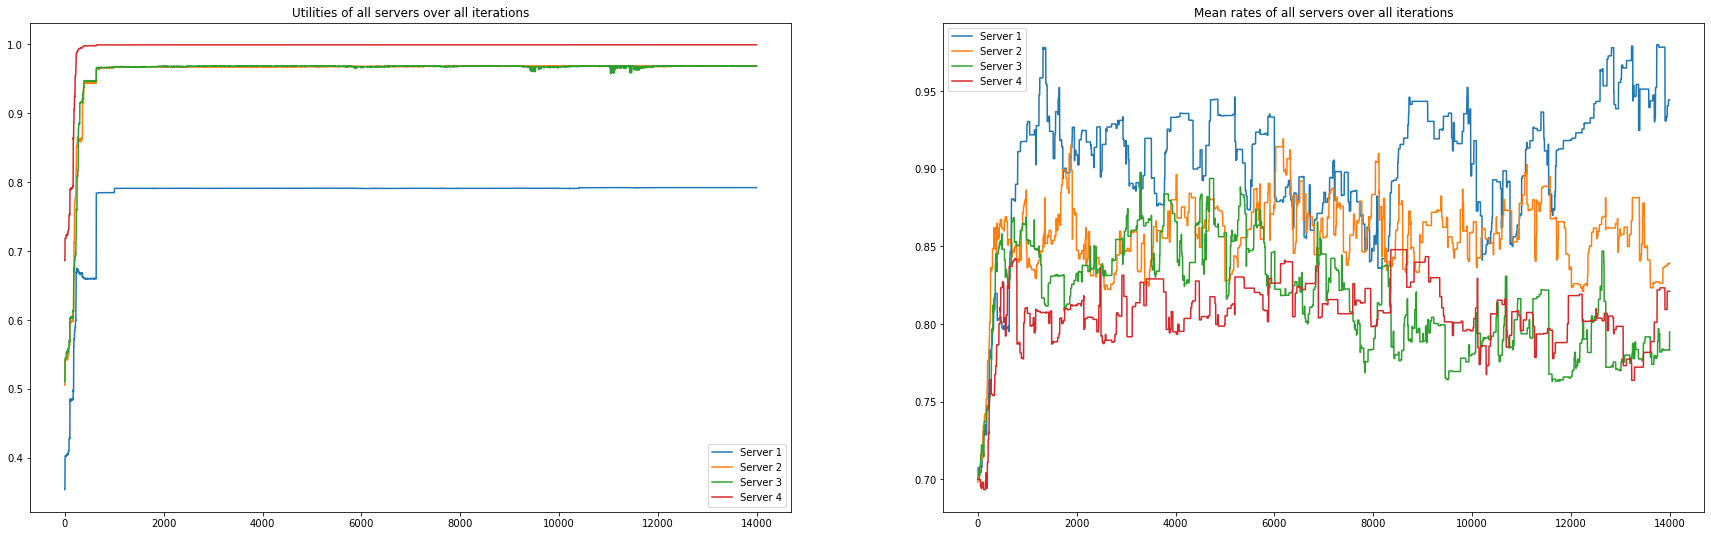

In [86]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 9))
for srv in range(num_of_servers):
    ax1.plot([util[srv] for util in utilities_01])
ax1.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax1.set_title("Utilities of all servers over all iterations")

for srv in range(num_of_servers):
    ax2.plot(mean_rates_01[srv])
    ax2.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax2.set_title("Mean rates of all servers over all iterations")

plt.show()

## Questions:
- What do these plots actually tell us?
- What is all that noise on the right graph?
- Why the big jump on the left graph?

Let us look at the actual matrices with each server's rates. Specifically server 1 at iteration 600 - 700.

In [87]:
num_of_servers = 4
threshold = 7
system_capacity = 10
buffer_capacity = 7

### Finding where the jump actually happens
Let us get the value where server 1's utility skyrockets:


In [88]:
# Found at iteration 636
print(utilities_01[635][0])
print(utilities_01[636][0])

0.661098632032249
0.78388793837089


### Function to reconstruct rates from saved file

In [89]:
import itertools

def reconstruct_rates(rates_from_file, system_capacity, buffer_capacity, threshold):
    """
    Reconstruct rates dictionary where it will be of the form:
        rates = dict{
            iteration : dict{
                server_id: dict{
                    state: rate
                    }
                }
            }
    """
    num_of_servers = len(rates_from_file)
    num_of_iterations = len(rates_from_file[0])
    num_of_states = len(rates_from_file[0][0])

    all_states = abg.markov.build_states(
        threshold=threshold,
        system_capacity=system_capacity,
        buffer_capacity=buffer_capacity
    )
    # Look at the change in main.py to understand why we need these if statements 
    # (short answer you are an idiot and you coded this the first time the wrong way)
    # If num_of_states == len(all_states) means that there is one entry for every 
    #   valid rate for each server 
    # Elif num_of_states == (system_capacity + 1) * (buffer_capacity + 1) means that
    #   there is one entry for all possible combinations of (u,v) where some are not valid
    
    # e.g. T=3, N=4, M=2 => state (1,1) does not exist in the first code block while
    #   it is on the second (stupid Mike)
    if num_of_states == len(all_states):
        raise NotImplementedError("This code block is not implemented yet")
    elif num_of_states == (system_capacity + 1) * (buffer_capacity + 1):
        rates = {}
        for iteration in range(num_of_iterations):
            rates[iteration] = {}
            for server_id in range(1, num_of_servers + 1):
                rates[iteration][server_id] = {}
                for index, (u, v) in enumerate(
                    itertools.product(
                        range(buffer_capacity + 1), range(system_capacity + 1)
                    )
                ):
                    if v >= threshold or u == 0:
                        rates[iteration][server_id][(u, v)] = rates_from_file[server_id - 1][iteration][index]
        return rates
    else:
        raise Exception("Dunno what you on about mate")

In [90]:
rates = reconstruct_rates(
    rates_from_file_01, system_capacity, buffer_capacity, threshold
)

```python
rates = dict{
    iteration : dict{
        server_id: dict{
            state: rate
            }
        }
    }
```

## Function to reconstruct matrix of rates from dictionary

In [91]:
def reconstruct_rates_matrix_from_dictionary(rates_dict):
    buffer_capacity, system_capacity = max(list(rates_dict.keys()))
    rates_array = np.empty((buffer_capacity + 1, system_capacity + 1)) * np.nan
    for (u, v), rate in rates_dict.items():
        rates_array[(u, v)] = rate
    return rates_array

In [92]:
# Increase print() output width
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

In [93]:
print("Utility:", utilities_01[635][0])
print("Server 1 rates: \n", reconstruct_rates_matrix_from_dictionary(rates[635][1]))

Utility: 0.661098632032249
Server 1 rates: 
 [[2.4 4.98 2.3 1.32 0.7 0.773 0.0437 1.39 1.18 0.128 0.7]
 [nan nan nan nan nan nan nan 0.7 0.7 0.7 0.7]
 [nan nan nan nan nan nan nan 0.809 1.33 0.7 0.7]
 [nan nan nan nan nan nan nan 1.3 0.7 0.47 0.429]
 [nan nan nan nan nan nan nan 0.7 0.7 0.7 0.7]
 [nan nan nan nan nan nan nan 0.7 0.7 0.7 0.7]
 [nan nan nan nan nan nan nan 0.7 0.7 0.7 0.7]
 [nan nan nan nan nan nan nan 0.7 0.7 0.7 0.7]]


In [94]:
print("Utility:", utilities_01[636][0])
print("Server 1 rates: \n", reconstruct_rates_matrix_from_dictionary(rates[636][1]))

Utility: 0.78388793837089
Server 1 rates: 
 [[4.74 4.98 2.3 1.32 0.7 0.773 0.0437 1.39 1.18 0.128 0.7]
 [nan nan nan nan nan nan nan 0.7 0.7 0.7 0.7]
 [nan nan nan nan nan nan nan 0.809 1.33 0.7 0.7]
 [nan nan nan nan nan nan nan 1.3 0.7 0.47 0.429]
 [nan nan nan nan nan nan nan 0.7 0.7 0.7 0.7]
 [nan nan nan nan nan nan nan 0.7 0.7 0.7 0.7]
 [nan nan nan nan nan nan nan 0.7 0.7 0.7 0.7]
 [nan nan nan nan nan nan nan 0.7 0.7 0.7 0.7]]


Comparing the rates array of server `1` at iterations `635` and `636` we can see that the only change that happened that resulted in the huge jump in the utility is that entry `[0, 0]` of the matrix almost doubled. That means that by increasing its service rate only for state `(0,0)` that increased its utility function which was mainly increasing server 1's idle time. 

That makes sense.

# Stuff you should do:
- For visualisation:
  - Instead of plotting the rates - plot the weighted probability using state probabilities and rates
    - You may to either implement that somewhere in the Reinforcement learning algorithm 
    - or even better just use the seed and rerun the simulations using the saved values of the rates
    - or use the markov probabilities?? (Don't know if that is actually a good idea, but it is definitely the easiest one to do)
    - Plot moving averages of the service rate graph
    - Merge utility plot and service rate plot into one (utilities bold, rates dashed)
  - Plot a heatmap of each server's rates
    - Get a video/gif where over time four heatmaps change (one for each server)
    - At the bottom of the video/gif is the plot of the utilities over time
    - Each frame would be one iteration of the Reinforcement learning
    - Vince did not love this idea
- For further understanding of the results OR improving the RL algorithm:
  - Look at how the matrices change
    - This was partly done above
    - But look at other examples apart from the one above 
    - (e.g look somehwere where there was no change in utility but massive change in rates to confirm that non-important changes were made)
  - Try different starting policies
    - Try different set of parameters
    - Plot the mean service rate instead of the mean of all service rates
  - Somehow get the probability distribution of all states and times it with each server's rate
    - Update the RL algorithm
    - Use probability distribution of the states and use that to pick the new state to update
    - Probabilistically based on that probability distribution

## Other examples (No change on utilities + Big change on rates) 

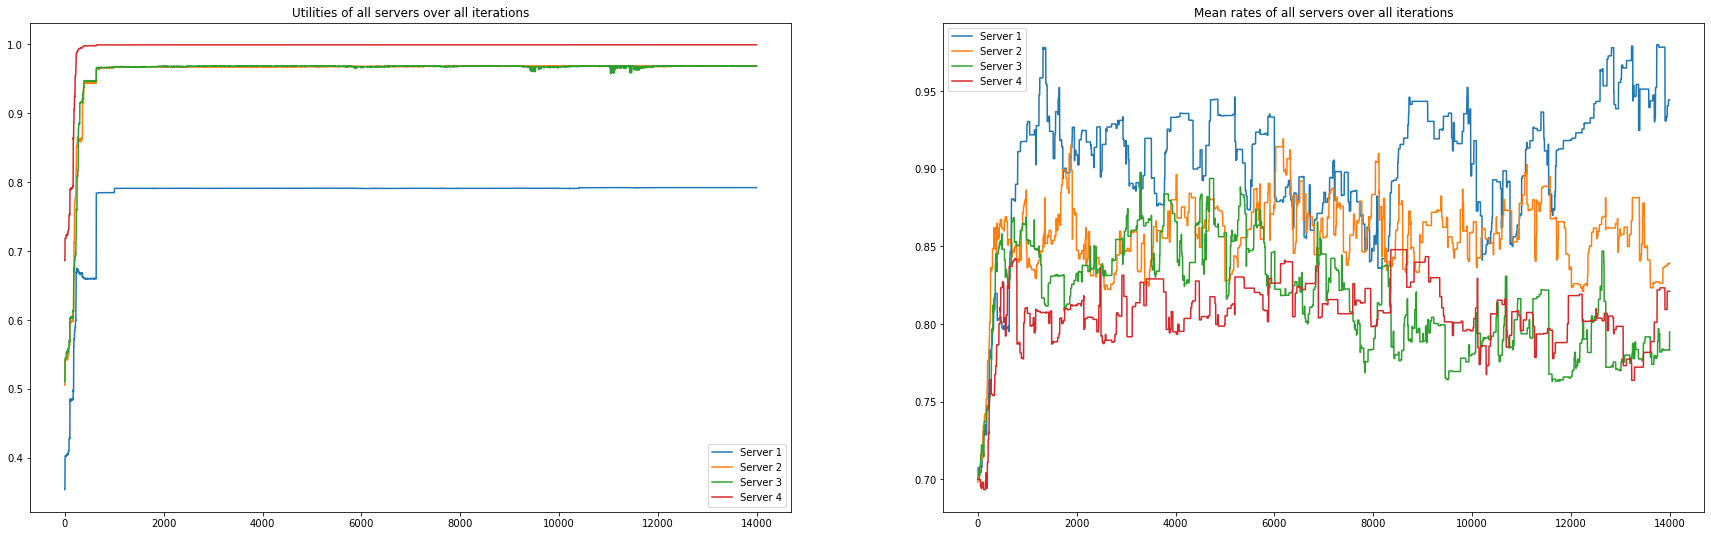

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 9))
for srv in range(num_of_servers):
    ax1.plot([util[srv] for util in utilities_01])
ax1.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax1.set_title("Utilities of all servers over all iterations")

for srv in range(num_of_servers):
    ax2.plot(mean_rates_01[srv])
    ax2.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax2.set_title("Mean rates of all servers over all iterations")

plt.show()

Identifying where is the first peak of server 1's mean rate

In [35]:
for i, value in enumerate(mean_rates_01[0]):
    if value > 0.97:
        print(i, value)
        break

1317 0.9780774089873246


On iteration `1317` the mean rates of server 1 gets an increase but the utilities stay the same.

In [34]:
change_iteration = 1316

print(f"Utility at iteration {change_iteration}:", utilities_01[change_iteration][0])
print("Rates: \n", reconstruct_rates_matrix_from_dictionary(rates[change_iteration][1]))
print()
print(f"Utility at iteration {change_iteration + 1}:", utilities_01[change_iteration + 1][0])
print("Rates: \n", reconstruct_rates_matrix_from_dictionary(rates[change_iteration + 1][1]))

Utility at iteration 1316: 0.79088798810378
Rates: 
 [[4.94 4.98 4.8 4.48 2.01 4.98 0.00165 1.39 1.18 0.128 0.7]
 [nan nan nan nan nan nan nan 0.7 0.7 0.7 0.7]
 [nan nan nan nan nan nan nan 0.809 1.33 0.7 0.7]
 [nan nan nan nan nan nan nan 1.3 0.7 0.47 0.429]
 [nan nan nan nan nan nan nan 0.7 0.7 0.7 0.7]
 [nan nan nan nan nan nan nan 0.7 0.7 0.7 0.7]
 [nan nan nan nan nan nan nan 0.7 0.7 0.7 0.7]
 [nan nan nan nan nan nan nan 0.7 0.7 0.7 0.7]]

Utility at iteration 1317: 0.790917273200979
Rates: 
 [[4.94 4.98 4.8 4.48 3.75 4.98 0.00165 1.39 1.18 0.128 0.7]
 [nan nan nan nan nan nan nan 0.7 0.7 0.7 0.7]
 [nan nan nan nan nan nan nan 0.809 1.33 0.7 0.7]
 [nan nan nan nan nan nan nan 1.3 0.7 0.47 0.429]
 [nan nan nan nan nan nan nan 0.7 0.7 0.7 0.7]
 [nan nan nan nan nan nan nan 0.7 0.7 0.7 0.7]
 [nan nan nan nan nan nan nan 0.7 0.7 0.7 0.7]
 [nan nan nan nan nan nan nan 0.7 0.7 0.7 0.7]]


We can observe NO visible change on the utilities. 

BUT the rate of server 1 at state `(0,4)` get an increase.

# Comparison between early iterations and later iterations

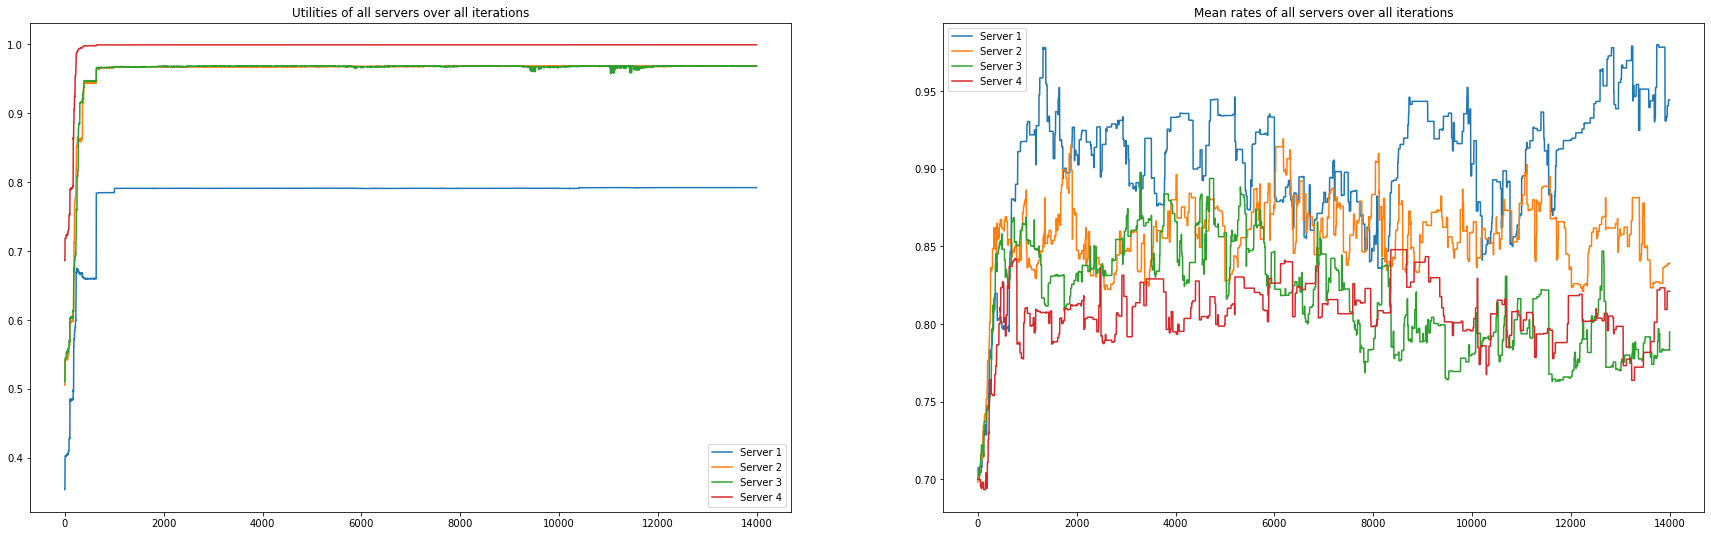

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 9))
for srv in range(num_of_servers):
    ax1.plot([util[srv] for util in utilities_01])
ax1.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax1.set_title("Utilities of all servers over all iterations")

for srv in range(num_of_servers):
    ax2.plot(mean_rates_01[srv])
    ax2.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax2.set_title("Mean rates of all servers over all iterations")

plt.show()

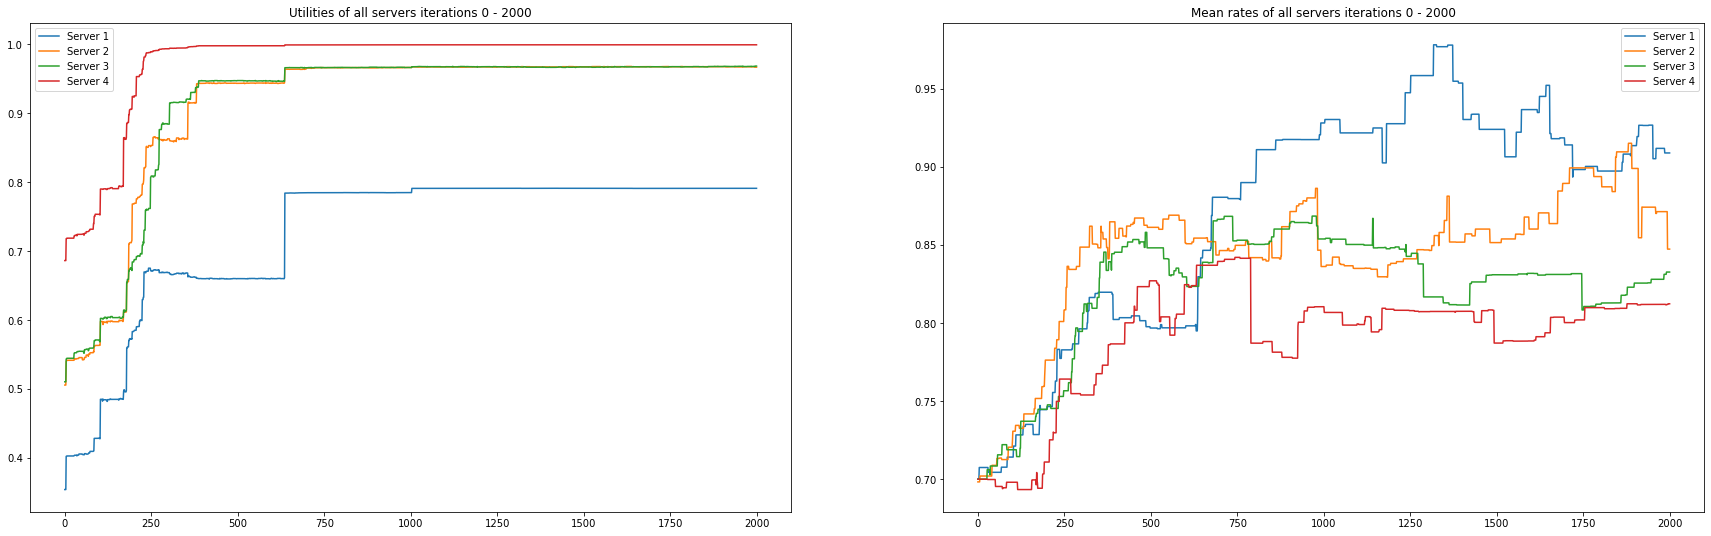

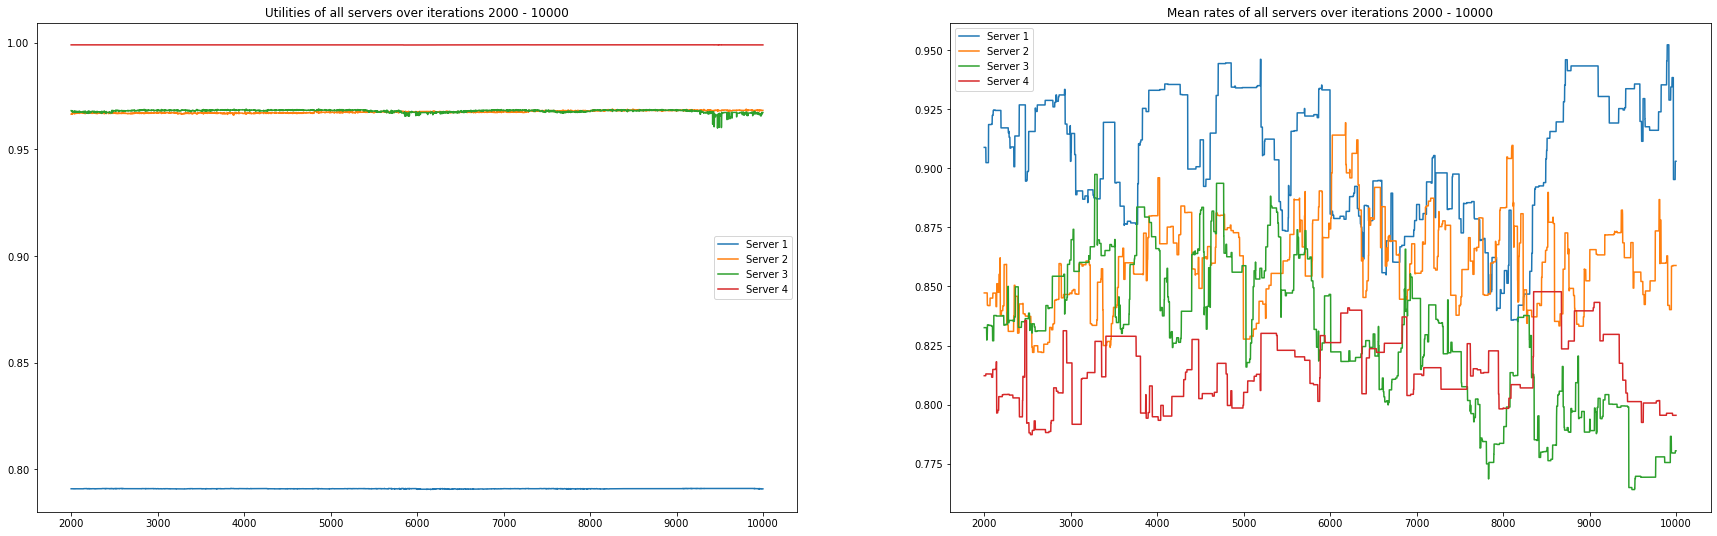

In [95]:
start = 0
end = 2000

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 9))
for srv in range(num_of_servers):
    ax1.plot(range(start, end), [util[srv] for util in utilities_01[start:end]])
ax1.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax1.set_title(f"Utilities of all servers iterations {start} - {end}")

for srv in range(num_of_servers):
    ax2.plot(range(start, end), mean_rates_01[srv][start:end])
ax2.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax2.set_title(f"Mean rates of all servers iterations {start} - {end}")

start = 2000
end = 10000

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 9))
for srv in range(num_of_servers):
    ax1.plot(range(start, end), [util[srv] for util in utilities_01[start:end]])
ax1.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax1.set_title(f"Utilities of all servers over iterations {start} - {end}")

for srv in range(num_of_servers):
    ax2.plot(range(start, end), mean_rates_01[srv][start:end])
ax2.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax2.set_title(f"Mean rates of all servers over iterations {start} - {end}")

plt.show()

## Server 1

In [96]:
import pandas as pd

In [97]:
server = 1

In [98]:
iteration_1 = 0
iteration_2 = 2000
print("Starting utility: ", utilities_01[iteration_1][server - 1])
print("Final utility: ", utilities_01[iteration_2][server - 1])
pd.DataFrame(reconstruct_rates_matrix_from_dictionary(rates[iteration_2][server]) - reconstruct_rates_matrix_from_dictionary(rates[iteration_1][server]))

Starting utility:  0.353837586151342
Final utility:  0.790856917922082


,0,1,2,3,4,5,6,7,8,9,10
0,4.238587,4.28317,3.939777,4.2183,1.605824,-0.645091,-0.699201,0.691229,0.483952,-0.571936,0.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.108536,0.629296,0.000000,0.000000
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.595891,0.000000,-0.229981,-0.270868
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000


In [99]:
iteration_1 = 2000
iteration_2 = 10000
print("Starting utility: ", utilities_01[iteration_1][server - 1])
print("Final utility: ", utilities_01[iteration_2][server - 1])
pd.DataFrame(reconstruct_rates_matrix_from_dictionary(rates[iteration_2][server]) - reconstruct_rates_matrix_from_dictionary(rates[iteration_1][server]))

Starting utility:  0.790856917922082
Final utility:  0.79082076408395


,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.0,0.33671,-3.950546,-0.523874,4.372789,-0.000794,-1.372090,0.000000,0.000000,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-0.648969,0.680138,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.241033,0.000000,0.000000,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.349641,0.000000,0.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0


## Server 2

In [44]:
server = 2

In [45]:
iteration_1 = 0
iteration_2 = 2000
print("Starting utility: ", utilities_01[iteration_1][server - 1])
print("Final utility: ", utilities_01[iteration_2][server - 1])
pd.DataFrame(reconstruct_rates_matrix_from_dictionary(rates[iteration_2][server]) - reconstruct_rates_matrix_from_dictionary(rates[iteration_1][server]))

Starting utility:  0.505424520008278
Final utility:  0.966541298019124


,0,1,2,3,4,5,6,7,8,9,10
0,-0.699777,4.036635,4.28071,-0.232202,1.0679,0.570391,-0.686907,-0.682154,0.670023,0.576726,0.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.391278,0.000000,0.000000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.086268,1.328562,0.328019,0.000000
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.017464,0.697623,0.000000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.603371,0.000000,0.000000,0.379797
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.385056,0.000000,0.000000
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.329785,0.000000,-0.162412,0.000000


In [46]:
iteration_1 = 2000
iteration_2 = 10000
print("Starting utility: ", utilities_01[iteration_1][server - 1])
print("Final utility: ", utilities_01[iteration_2][server - 1])
pd.DataFrame(reconstruct_rates_matrix_from_dictionary(rates[iteration_2][server]) - reconstruct_rates_matrix_from_dictionary(rates[iteration_1][server]))

Starting utility:  0.966541298019124
Final utility:  0.96835012772318


,0,1,2,3,4,5,6,7,8,9,10
0,-0.000223,0.214984,-0.021922,0.439187,1.802259,-1.202419,-0.01309,-0.002725,0.0,0.0,0.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.000000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,-0.017721
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.000000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.000000
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.000000
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.000000
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,-0.177180


## Server 3

In [47]:
server = 3

In [48]:
iteration_1 = 0
iteration_2 = 2000
print("Starting utility: ", utilities_01[iteration_1][server - 1])
print("Final utility: ", utilities_01[iteration_2][server - 1])
pd.DataFrame(reconstruct_rates_matrix_from_dictionary(rates[iteration_2][server]) - reconstruct_rates_matrix_from_dictionary(rates[iteration_1][server]))

Starting utility:  0.510186815356404
Final utility:  0.968194386932939


,0,1,2,3,4,5,6,7,8,9,10
0,-0.699786,4.150084,4.227514,0.910873,0.094243,-0.13241,2.20904,-0.202395,0.000000,0.000000,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-0.111512,0.733405,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.249664,0.000000,0.000000,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-0.202116,0.502961,0.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-0.061367,0.000000,0.0


In [49]:
iteration_1 = 2000
iteration_2 = 10000
print("Starting utility: ", utilities_01[iteration_1][server - 1])
print("Final utility: ", utilities_01[iteration_2][server - 1])
pd.DataFrame(reconstruct_rates_matrix_from_dictionary(rates[iteration_2][server]) - reconstruct_rates_matrix_from_dictionary(rates[iteration_1][server]))

Starting utility:  0.968194386932939
Final utility:  0.967317430287075


,0,1,2,3,4,5,6,7,8,9,10
0,-0.000214,0.113402,-0.554812,0.737098,-0.614705,-0.561633,-2.906,-0.492405,0.000000,0.000000,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.333895,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.357301,0.000000,0.000000,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-0.315365,0.000000,0.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-0.678723,0.0


## Server 4

In [109]:
server = 4

In [110]:
iteration_1 = 0
iteration_2 = 2000
print("Starting utility: ", utilities_01[iteration_1][server - 1])
print("Final utility: ", utilities_01[iteration_2][server - 1])
pd.DataFrame(reconstruct_rates_matrix_from_dictionary(rates[iteration_2][server]) - reconstruct_rates_matrix_from_dictionary(rates[iteration_1][server]))

Starting utility:  0.6860308191774706
Final utility:  0.9990499556767073


,0,1,2,3,4,5,6,7,8,9,10
0,-0.699886,-0.631543,-0.616537,4.277835,3.995889,2.334897,-0.302618,1.062207,0.000000,0.000000,0.048652
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.599586,0.000000,0.052040,0.000000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.567981,-0.391733,0.013039,0.000000
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.412181,0.667707,0.000000,0.000000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-0.123420,0.000000,0.000000
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.018766,0.656076,0.000000,0.000000
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000


In [112]:
iteration_1 = 2000
iteration_2 = 10000
print("Starting utility: ", utilities_01[iteration_1][server - 1])
print("Final utility: ", utilities_01[iteration_2][server - 1])
pd.DataFrame(reconstruct_rates_matrix_from_dictionary(rates[iteration_2][server]) - reconstruct_rates_matrix_from_dictionary(rates[iteration_1][server]))

Starting utility:  0.9990499556767073
Final utility:  0.9990305440675618


,0,1,2,3,4,5,6,7,8,9,10
0,-0.000114,-0.068457,-0.083463,0.0,0.150544,-1.588672,-0.159982,0.157582,0.118173,0.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0


## Plot: $ \text{rates} \times \text{states probabilities} $

#### Current plot

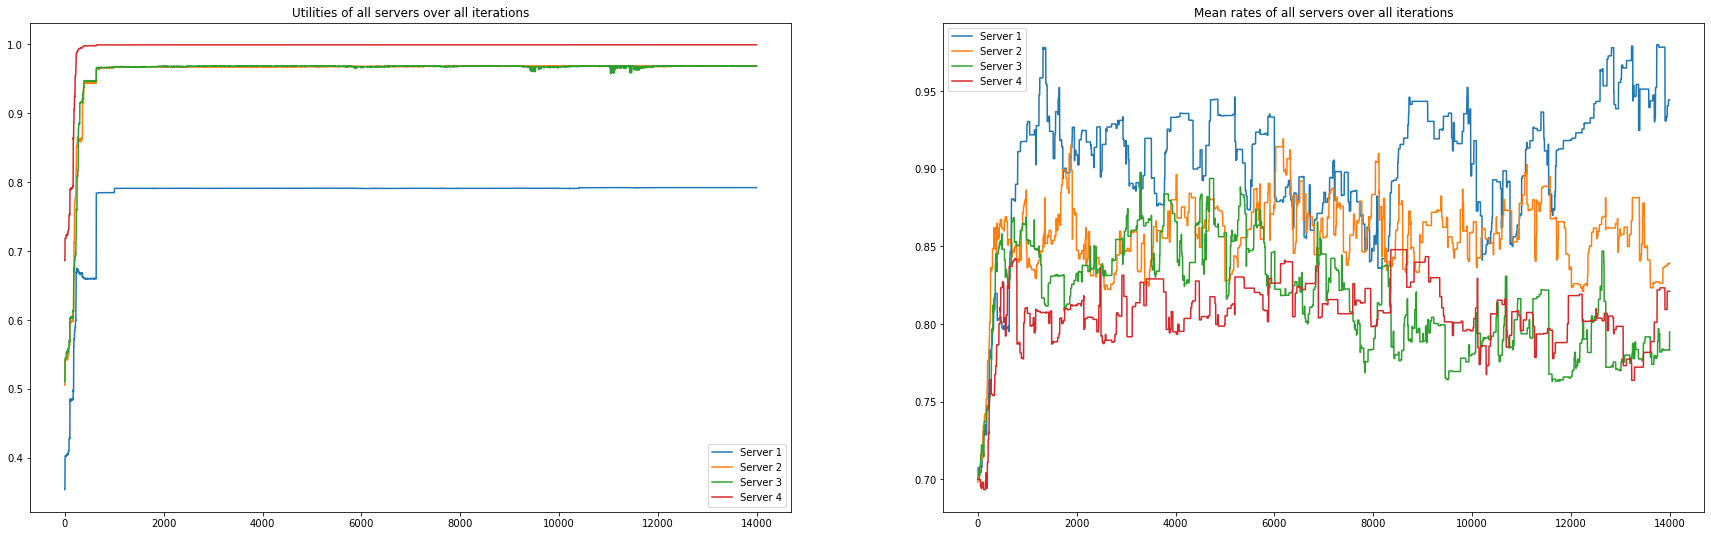

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 9))
for srv in range(num_of_servers):
    ax1.plot([util[srv] for util in utilities_01])
ax1.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax1.set_title("Utilities of all servers over all iterations")

for srv in range(num_of_servers):
    ax2.plot(mean_rates_01[srv])
    ax2.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax2.set_title("Mean rates of all servers over all iterations")

plt.show()

### Markov chain (naive) approximation plot

In [78]:
# Parameters
lambda_2 = 1
lambda_1 = 0.5
mu = 0.85 # 0.7, 0.9, 1
num_of_servers = 4
threshold = 7
system_capacity = 10
buffer_capacity = 7

In [79]:
# Steady state probabilities USING MARKOV MODEL
all_states = abg.markov.build_states(
    threshold=threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
)
transition_matrix = abg.markov.get_transition_matrix(
    lambda_1=lambda_1, 
    lambda_2=lambda_2, 
    mu=mu, 
    num_of_servers=num_of_servers, 
    threshold=threshold, 
    system_capacity=system_capacity, 
    buffer_capacity=buffer_capacity
)
pi = abg.markov.get_steady_state_algebraically(transition_matrix)
pi_dict = abg.markov.get_markov_state_probabilities(pi, all_states, output=dict)

## e = 0.1

In [80]:
# Reconstruct rates from file
rates_all_iterations_all_servers = reconstruct_rates(
    rates_from_file_01, system_capacity, buffer_capacity, threshold
)

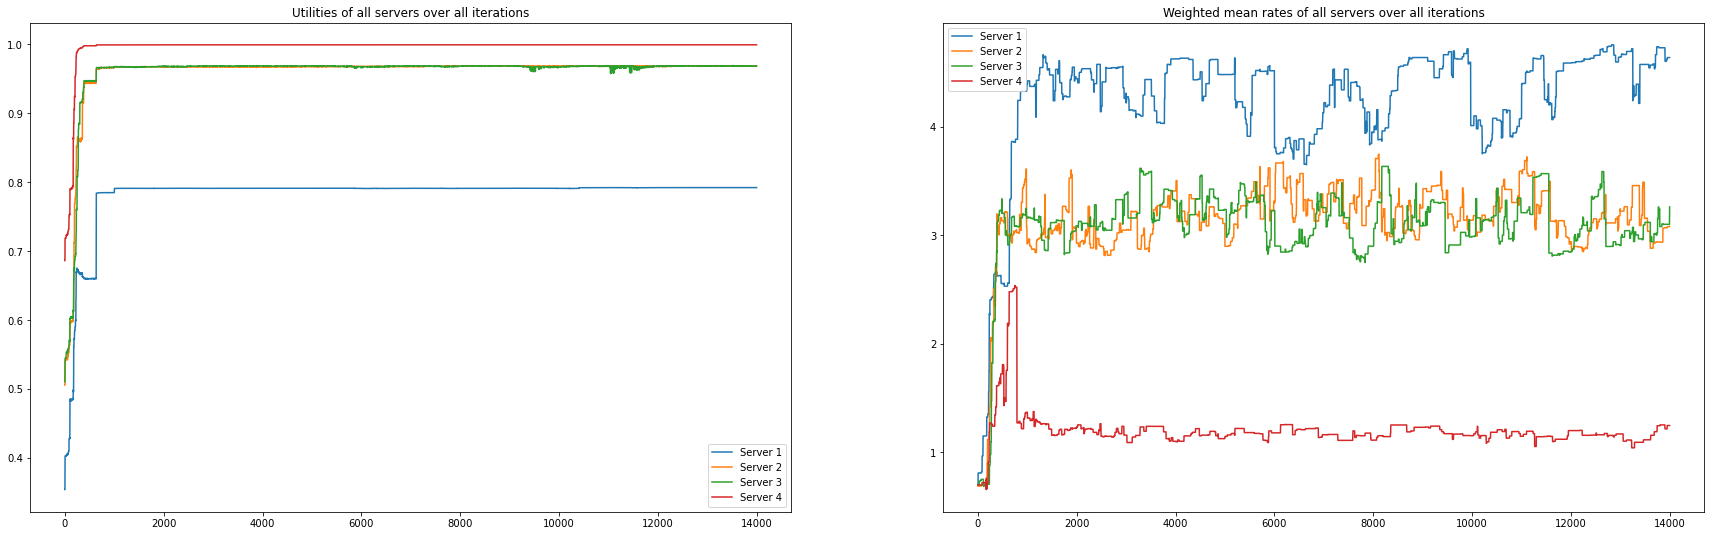

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 9))
for srv in range(num_of_servers):
    ax1.plot([util[srv] for util in utilities_01])
ax1.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax1.set_title("Utilities of all servers over all iterations")

for srv in range(1, num_of_servers + 1):
    server_mean_weighted_rates = []
    for itr in range(len(rates_all_iterations_all_servers)):
        current_iteration_mean_weighted_rate = 0
        for state in all_states:
            current_iteration_mean_weighted_rate += (
                rates_all_iterations_all_servers[itr][srv][state] * pi_dict[state]
            )
        server_mean_weighted_rates.append(current_iteration_mean_weighted_rate)
    ax2.plot(server_mean_weighted_rates)
ax2.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax2.set_title("Weighted mean rates of all servers over all iterations")

plt.show()

## e = 0.5

In [82]:
# Reconstruct rates from file
rates_all_iterations_all_servers = reconstruct_rates(
    rates_from_file_05, system_capacity, buffer_capacity, threshold
)

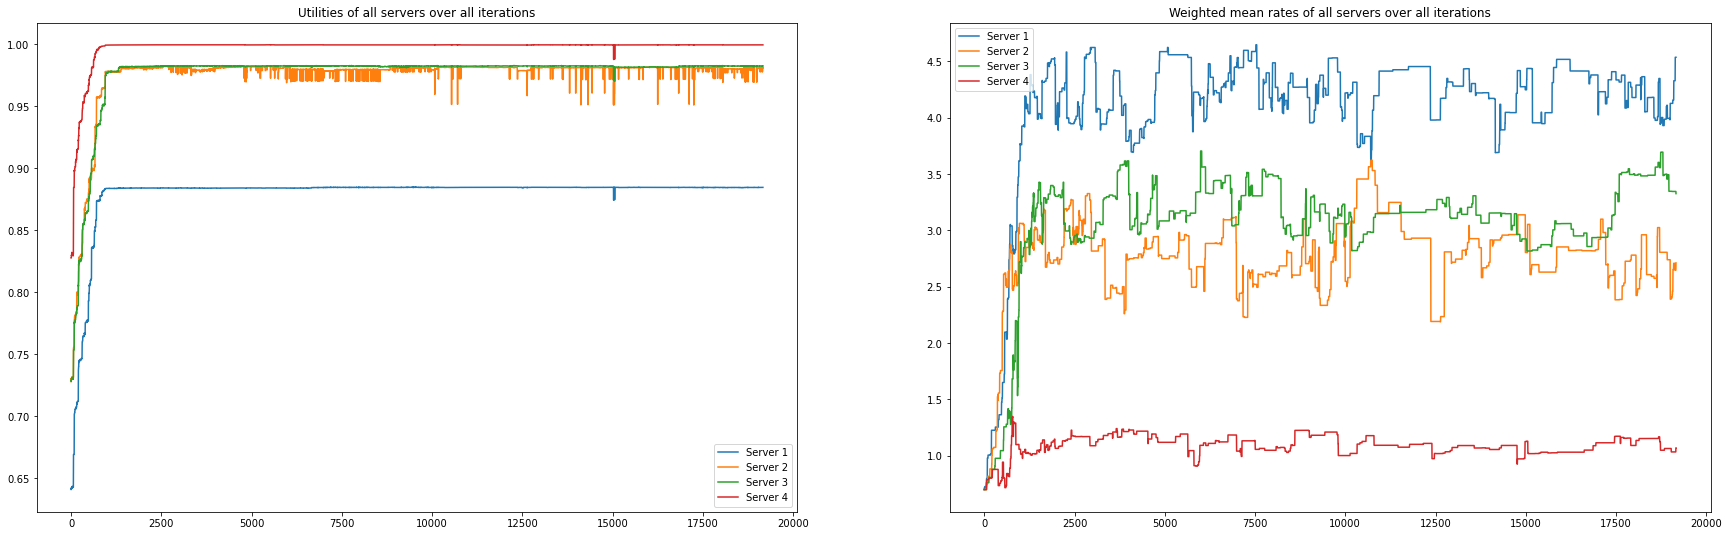

In [83]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 9))
for srv in range(num_of_servers):
    ax1.plot([util[srv] for util in utilities_05])
ax1.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax1.set_title("Utilities of all servers over all iterations")

for srv in range(1, num_of_servers + 1):
    server_mean_weighted_rates = []
    for itr in range(len(rates_all_iterations_all_servers)):
        current_iteration_mean_weighted_rate = 0
        for state in all_states:
            current_iteration_mean_weighted_rate += (
                rates_all_iterations_all_servers[itr][srv][state] * pi_dict[state]
            )
        server_mean_weighted_rates.append(current_iteration_mean_weighted_rate)
    ax2.plot(server_mean_weighted_rates)
ax2.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax2.set_title("Weighted mean rates of all servers over all iterations")

plt.show()

## e = 0.9

In [84]:
# Reconstruct rates from file
rates_all_iterations_all_servers_09 = reconstruct_rates(
    rates_from_file_09, system_capacity, buffer_capacity, threshold
)

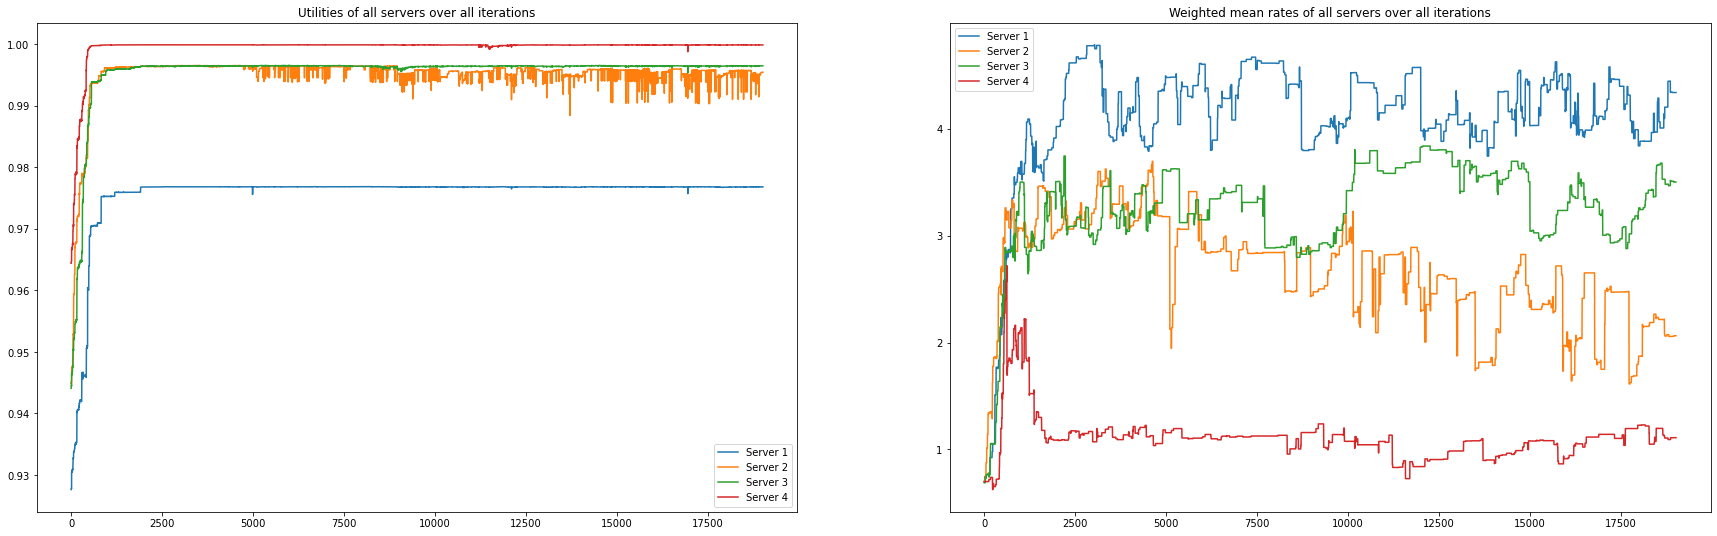

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 9))
for srv in range(num_of_servers):
    ax1.plot([util[srv] for util in utilities_09])
ax1.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax1.set_title("Utilities of all servers over all iterations")

for srv in range(1, num_of_servers + 1):
    server_mean_weighted_rates = []
    for itr in range(len(rates_all_iterations_all_servers_09)):
        current_iteration_mean_weighted_rate = 0
        for state in all_states:
            current_iteration_mean_weighted_rate += (
                rates_all_iterations_all_servers_09[itr][srv][state] * pi_dict[state]
            )
        server_mean_weighted_rates.append(current_iteration_mean_weighted_rate)
    ax2.plot(server_mean_weighted_rates)
ax2.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax2.set_title("Weighted mean rates of all servers over all iterations")

plt.show()

## Playground